## Extract html tables from Wikipedia pages

Difference between librairies in R.

### 1) A simple example

We use the page of wikipedia "List_of_countries_and_dependencies_by_population" as an example.

In [1]:
base <- "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"

### a-] Library XML

Need RCurl for the getURL fonction, then we parse the html code.

In [2]:
library(XML)
library(RCurl)

XML_res <- readHTMLTable(htmlParse(getURL(base),asText=TRUE), header=T)[[1]]

XML_res[0:5,]

Warning message:
“package ‘XML’ was built under R version 3.2.5”Warning message:
“package ‘RCurl’ was built under R version 3.2.5”Loading required package: bitops


Rank,Country(or dependent territory),Population,Date,% of worldpopulation,Source
1,China[Note 2],"1,395,570,000","December 6, 2018",18.2%,Official population clock
2,India[Note 3],"1,340,480,000","December 6, 2018",17.5%,Official population clock
3,United States[Note 4],"328,298,000","December 6, 2018",4.28%,Official population clock
4,Indonesia,"265,015,300","July 1, 2018",3.46%,Official annual projection
5,Brazil,"209,942,000","December 6, 2018",2.74%,Official population clock


The function readHTMLTable returns a list of tables, we just call the first table with [[1]]. If we want the second tables of this page:

In [3]:
readHTMLTable(htmlParse(getURL(base),asText=TRUE), header=T)[[2]][0:5,]

V1,V2
Global,Current population Current population (United Nations)
(Sub-)continents,Africa Asia Europe North America Caribbean Oceania South America
Intercontinental,Americas Arab world Commonwealth of Nations Eurasia European Union Islands Latin America Middle East
Cities/urban regions,National capitals Cities proper Metropolitan areas Urban areas Megacities Megalopolises
Past and future,Past population (United Nations estimates) Past and future population 1 1000 1500 1600 1700 1800 1900 1907 1939 1989 2000 2005 2010 population milestones Future population


### b-] Library xml2

Based on the libxml2 C library

The rvest library allows to use the %>%

In [4]:
library(xml2)
library(rvest)

xml2_res <- (read_html(base) %>% html_table)[[1]]
xml2_res[0:5,]

Warning message:
“package ‘xml2’ was built under R version 3.2.5”Warning message:
“package ‘rvest’ was built under R version 3.2.5”
Attaching package: ‘rvest’

The following object is masked from ‘package:XML’:

    xml



Rank,Country(or dependent territory),Population,Date,% of worldpopulation,Source
1,China[Note 2],"1,395,570,000","December 6, 2018",18.2%,Official population clock
2,India[Note 3],"1,340,480,000","December 6, 2018",17.5%,Official population clock
3,United States[Note 4],"328,298,000","December 6, 2018",4.28%,Official population clock
4,Indonesia,"265,015,300","July 1, 2018",3.46%,Official annual projection
5,Brazil,"209,942,000","December 6, 2018",2.74%,Official population clock


Difference between the title of xml2 and XML in the second table. xml2 seems to be better.

In [5]:
(read_html(base) %>% html_table)[[2]][0:5,]

vteLists of countries by population statistics,vteLists of countries by population statistics
Global,Current population Current population (United Nations)
(Sub-)continents,Africa Asia Europe North America Caribbean Oceania South America
Intercontinental,Americas Arab world Commonwealth of Nations Eurasia European Union Islands Latin America Middle East
Cities/urban regions,National capitals Cities proper Metropolitan areas Urban areas Megacities Megalopolises
Past and future,Past population (United Nations estimates) Past and future population 1 1000 1500 1600 1700 1800 1900 1907 1939 1989 2000 2005 2010 population milestones Future population


### c-] Library htmlTab

To read: https://cran.r-project.org/web/packages/htmltab/vignettes/htmltab.html

In [6]:
library(htmltab)

htmltab_res <- htmltab(doc = base, which = 1)
htmltab_res[0:5,]

ERROR: Error in library(htmltab): there is no package called ‘htmltab’


The [Note 2] from the chinese line are not in the table with htmltab. This library add a index for each line.

In [7]:
htmltab(doc = base, which = 2)[0:5,]

ERROR: Error in eval(expr, envir, enclos): impossible de trouver la fonction "htmltab"


### 2) On multiple pages, do the tables has the same number of tables/lines/columns?

To see all the links:
https://github.com/acherm/wikipediamatrix-bench/blob/master/wikimatrix/inputdata/wikiurls.txt

Just add "https://en.wikipedia.org/wiki/" before the adress.

In this part, we don't want to compare all the values, but just the number of lines and columns for each library.

In [8]:
links <- read.table("https://raw.githubusercontent.com/acherm/wikipediamatrix-bench/master/wikimatrix/inputdata/wikiurls.txt",
                    header = F)
nbLinks <- nrow(links)

### a-] Library XML

In [9]:
start_timeXML <- Sys.time() # to measure the performance of the extraction

nbLinesXML <- rep(-1, nbLinks) # If the number of lines is equal to -1, that means the extraction has failed somehow
nbColumnsXML <- rep(-1, nbLinks)
nbTablesXML <- rep(-1, nbLinks)

for(indexLink in 1:nbLinks){
    # The full adress
    link <- paste("https://en.wikipedia.org/wiki/", links$V1[indexLink], sep="")
    # extraction of the html_code
    html_code <- getURL(link)
    # if the page is not empty
    if(html_code != ""){
        # Then we parse the html code, and we extract the tables
        XML_res <- readHTMLTable(htmlParse(html_code), header=T)
        # if there is a table in the page
        if(length(XML_res) != 0){
            nbTablesXML[indexLink] <- length(XML_res)
            # then we add the total number of row/columns of the biggest table of the webpage
            for(table in XML_res){
                nbLinesXML[indexLink] <- max(nbLinesXML[indexLink], nrow(table))
                nbColumnsXML[indexLink] <- max(nbColumnsXML[indexLink], length(table))
            }
        }
    }
}

end_timeXML <- Sys.time()

print("Extraction from the tables with XML")
end_timeXML-start_timeXML

[1] "Extraction from the tables with XML"


Time difference of 2.228547 mins

In [10]:
nbLinesXML

[1]  23  15  30  28  29  51  18 188  22  38 112  14  10  10  28   7 254  24
 [19]  88  13  53 137 162  23  16  32  32  -1  21  30  80  23 402  10 126  23
 [37]  12  39   8  26  38  61   8 207 492 274  21  10  16  30  13   9  24   5
 [55]  12  28  10 413  28  68 456   9  23  32  32  10  10  35  10  34  45  23
 [73]  17 593  23  24  31   3  39  10  17  10  33  10  23  16  10   8  11  10
 [91]   7  39  21   4  26  37  26  10  36  30  22  23  45   6  19  10  14   3
[109]   7  61  31  17   7  30  10  18  29  29  19  25   9  10  13  23  35  24
[127]  14  10  29  28  25  16   7  41  19  14  26   5  14  56   8  17  10  10
[145]  41 154  38  29  38  29  22  63   5  61  46  25  53  21  24  58   1  51
[163]  17 113   8  17  21  48  19  27  30  23  24 139  38  16  61   5  34  21
[181]  20  16  31  23  18  53  55  12 245  55  25  60  60   9  10  38  14  23
[199]  15  22  24  36 146  78 103  29 133  57 134  39  25  24  10  29   9  32
[217]  31  54  23  22  24  28  10  57   5   6  21  69  11 103  13  32  48  49
[235]  36  49  59  97   7  10  31  21  47  27  20  26  18   6  57  63   8  10
[253]  55  13  73  21  31  26  55  22  26  15  37  60   8  60 201  12  29  20
[271] 141  28  20  45  67  21  55  25  16  20  21  57  48  29  26  10  76  45
[289]  41  28  16  73  25  41  23  37  26  21   6  98  56  18  33  14  33  51
[307]  21  54  39  41  43 359  45  40  10  14  42 107  94  43  47  60  31  45
[325]  30  10 118  10  13  39  32  56  57  25  24  28

In [11]:
nbColumnsXML

[1] 32  4 15  4 16  4  3  3 18 12 10  3  3  2 22  6  6  3 18  3  6 10  9  7 12
 [26] 11 21 -1 10 16 35 14  9  2 18  8  4  9  2  8  3 13  3  3  3  4  5  2  3  2
 [51]  7  7  9 10  5 11  2 11 10  9  3  3 14  4  8  2  2  7  2 15 10  2 10  4  5
 [76] 21  3  4  3  7  6 11  5  2 10  8  2  3  3  8  6 14 10  2  9 12  4  2  7  8
[101] 10 22  3  2  9  9 12 13 10 12  6  4  7  6  2  7 12  9  5 15  3  2  6  8 11
[126]  6  7  2  7  8  6  7  7  9  8  7  7  3  3  3  6 11  2  2 27 16 13 13 14 10
[151] 26 77 19  8 16  8 12 10 10 27 12 79  3 12  8 11 12 16  8 14 15 20 19 13 10
[176]  9  7  6 11  8 14 16 15 16  9 11 11 21 14  7 19 10 10  8  2 18 14 16  6 16
[201] 10 16  9 16 12  7 11  8  9 10 13 13  9 18 16 13  9  9 10  4  6 17  2 11  9
[226]  9 10 79 16 14  9 23 18 23 14 25 13  9 14  2 10 11 30 10 13  8 16 17 13 12
[251] 20 12 12 10 11 17 17 11 17 13 15 10 12 10  8 10  8 13  9  8 25 16 16  8 15
[276]  3 13 13 19 11 15 30 14 18 11  2 12 19 12 17  9 16 13 18 16 23 20 16 13 13
[301]  6 12 13 13 20 13 15 13 14 15 12  8 18 19  2 13 10 35 16 15 16 10 20 12 25
[326]  2 18  2 18 39 16 25 24 22  8 44

In [12]:
nbTablesXML

[1] 19 13 13  9 10  2  3  4 12 10  5 12  6  2  6  5  5 15 12  8 10 24  3 41  4
 [26] 17  3 -1  3 34 10  5 10  2  3 19  5 16  6 19 48 14  5  1  5  4  1  2  5 19
 [51]  1  2  1  1  4  1  2  2  4  1  1  4  2  3  4  2  2  2  2  9  9  9  2  4  3
 [76] 15  2  6  2  1  1  2  6  2  5  5  2  4  5  2  4  4  1  2  8  5  1  2  4  5
[101]  1  5  6  3  2  1  1  2  2  2  3  8  3  8  2  6  2 38  1 19  3  2  1  3  1
[126]  5  5  2 18  2  1  2  3  3  1  3  3  7  9  7  6  7  2  2 14 10  2  6  7  2
[151]  2  3  1  2  1  8  1  4  3  2  2  3  8  4  8  3  2  1  6 12  5  5  1  2  3
[176]  4  5  6  7  2  2  1  2  4  3  4  3  3  3  6  4 38 38  4  2  4  3  4  4  1
[201]  3  1  6  2  4  5  5  7  4  4  3  3  3  7  3  4  5  6 12  2  9  4  2  4 11
[226]  5  6 26  3  6  8  7  1  1  3  1  8  7  2  2  8 19 17 25  9  7  5  3  5 12
[251]  4  8  5  7  5  5  5  5  3 12  9  8  6 38  7 38  3  5  6  1  5  8  9  5  9
[276] 42  7  6  5 16  5  6 12  5  8  2 17  4 10 13  6  5 27 13  4  2 11  6  7  7
[301] 17  6 10 15 11 12 10 12  8 12 11 16  3 15  2  7  4 19 12 21 23 38 13 18 80
[326]  2 17  2 21 91 25 10 14 33 24 15

Just one page does not contains table, if we suppose all the element of the list was really a table of data.

### b-] Library xml2

In [13]:
start_timeXml2 <- Sys.time() # to measure the performance of the extraction

nbLinesXml2 <- rep(-1, nbLinks) # If the number of lines is equal to -1, that means the extraction has failed somehow
nbColumnsXml2 <- rep(-1, nbLinks)
nbTablesXml2 <- rep(-1, nbLinks)

for(indexLink in 1:nbLinks){
    # The full adress
    link <- paste("https://en.wikipedia.org/wiki/", links$V1[indexLink], sep="")
    # avoid the 404 error if the page does not exists
    if (httr::GET(link)[2] != 404 &&  !(indexLink %in% c(73,327)) ){
        # pages 73 and 327 impossible to fix
        # if not, we can ask for the code
        xml2_res <- html_table(read_html(link), fill= T, trim=F)
        # if there is a table in the page
        if(length(xml2_res) != 0){
            nbTablesXml2[indexLink] <- length(xml2_res)
            # then we add the total number of row/columns of the biggest table of the webpage
            for(table in xml2_res){
                nbLinesXml2[indexLink] <- max(nbLinesXml2[indexLink], nrow(table))
                nbColumnsXml2[indexLink] <- max(nbColumnsXml2[indexLink], length(table))
            }
        }
    }
    
}

end_timeXml2 <- Sys.time()

print("Extraction from the tables with xml2 : ")
end_timeXml2-start_timeXml2

Warning message in strptime(x, fmt, tz = "GMT"):
“unknown timezone 'zone/tz/2018g.1.0/zoneinfo/Europe/Paris'”

[1] "Extraction from the tables with xml2 : "


Time difference of 2.203604 mins

In [14]:
nbLinesXml2

[1]  23  15  30  28  29  51  18 188  22  38 112  14  10  -1  28   7 254  24
 [19]  88  13  53 137 162  23  16  32  32  -1  21  30  80  23 402  -1 127  23
 [37]  12  39   9  26  38  61   8 207 492 274  21  -1  16  30  13   9  24   5
 [55]  12  28  -1 413  28  68 456   9  23  32  32  -1  -1  35  -1  34  45  23
 [73]  -1 593  23  24  31   4  39  10  17  10  33  -1  23  16  -1   8  11  10
 [91]   7  39  21   4  26  37  26  -1  36  30  22  23  45   6  19  10  14   3
[109]   7  61  31  17   7  30  -1  18  29  29  19  25   9  -1  13  23  35  24
[127]  14  -1  29  28  25  16   7  41  19  14  26   5  14  56   8  17  -1  -1
[145]  41 154  38  29  38  29  22  63   5  61  46  25  53  21  24  59   1  51
[163]  17 113   8  17  21  48  19  27  30  23  24 139  38  16  61   5  34  21
[181]  20  16  31  23  18  53  55  13 245  55  25  60  60   9  -1  38  14  23
[199]  15  22  24  36 146  78 103  29 133  57 134  39  25  24  10  29   9  32
[217]  31  54  23  22  24  28  -1  57   5   6  21  69  11 103  14  32  48  49
[235]  36  49  59  97   7  -1  31  21  47  27  20  26  18   6  57  63   8  10
[253]  55  13  73  21  31  26  55  22  26  15  37  60   8  60 201  12  29  20
[271] 142  28  20  45  67  21  55  25  16  20  21  57  48  29  26  -1  76  45
[289]  41  28  16  73  25  41  23  37  26  21   6  98  56  18  33  14  33  51
[307]  21  54  39  41  43 359  45  40  -1  14  42 107  94  43  47  60  31  45
[325]  30  -1  -1  -1  13  39  32  56  57  25  24  28

In [15]:
nbColumnsXml2

[1]   32   16   16   16   16    4    3    3   18   16   10    8    8   -1   22
 [16]    6   26   12   18    7    7   10    9   32   12   18   21   -1   10   16
 [31]   35   14   12   -1   18    8    4   16    2    8    3   13    3    3 1473
 [46]    4    5   -1   10   26    7    7    9   10    6   11   -1   11   10    9
 [61]    3    3   14   14    8   -1   -1    7   -1  258   20   23   -1    4    5
 [76]   21    3    8    3    7    6   11    5   -1   10    8   -1    6    3    8
 [91]    6   14   10    2   14   12    4   -1    7    8   10   22    6    2    9
[106]    9   12   13   10   12    6   10    7   10   -1   12   12    9    5   15
[121]    3   -1    6   11   11    8    7   -1   10    8    6    7    7   10    8
[136]    7    7    3    3    3    6   14   -1   -1   27   16   13   13   14   10
[151]   26 1768   19    8   16   32   12   10   10   27   12 1036   15   12    8
[166]   11   12   16   14   43   15   20   19   13   10    9    7    6   28    8
[181]   14   16   15   16    9   11   11   21   14   12   19   10   10    8   -1
[196]   18   14   16    6   16   10   16   16   16   13    7   11    8    9   11
[211]   13   13    9   18   16   13    9    9   16    4    6   17   -1   11    9
[226]    9   10 1768   16   14    9   23   18   23   14   25   13    9   14   -1
[241]   10   16   30   18   13    8   16   17   13   26   20   12   12   10   11
[256]   17   17   11   17   13   15   10   12   10    8   10    8   13    9    8
[271]   25   16   16    8   15   10   13   13   19   18   15   30   14   18   11
[286]   -1   17   19   12   20    9   16   16   20   16   23   20   16   13   13
[301]   10   12   13   13   20   13   15   13   15   15   12    8   18   20   -1
[316]   13   10   35   16   15   20   10   20   12   25   -1   -1   -1   18   39
[331]   16   25   24   22    8   44

In [16]:
nbTablesXml2

[1] 19 13 13  9 10  2  3  4 12 10  5 12  6 -1  6  5  5 15 12  8 10 24  3 41  4
 [26] 17  3 -1  3 34 10  5 10 -1  3 19  5 16  6 19 48 14  5  1  5  4  1 -1  5 19
 [51]  1  2  1  1  4  1 -1  2  4  1  1  4  2  3  4 -1 -1  2 -1  9  9  9 -1  4  3
 [76] 15  2  6  2  1  1  2  6 -1  5  5 -1  4  5  2  4  4  1  2  8  5  1 -1  4  5
[101]  1  5  6  3  2  1  1  2  2  2  3  8  3  8 -1  6  2 38  1 19  3 -1  1  3  1
[126]  5  5 -1 18  2  1  2  3  3  1  3  3  7  9  7  6  7 -1 -1 14 10  2  6  7  2
[151]  2  3  1  2  1  8  1  4  3  2  2  3  8  4  8  3  2  1  6 12  5  5  1  2  3
[176]  4  5  6  7  2  2  1  2  4  3  4  3  3  3  6  4 38 38  4 -1  4  3  4  4  1
[201]  3  1  6  2  4  5  5  7  4  4  3  3  3  7  3  4  5  6 12  2  9  4 -1  4 11
[226]  5  6 26  3  6  8  7  1  1  3  1  8  7  2 -1  8 19 17 25  9  7  5  3  5 12
[251]  4  8  5  7  5  5  5  5  3 12  9  8  6 38  7 38  3  5  6  1  5  8  9  5  9
[276] 42  7  6  5 16  5  6 12  5  8 -1 17  4 10 13  6  5 27 13  4  2 11  6  7  7
[301] 17  6 10 15 11 12 10 12  8 12 11 16  3 15 -1  7  4 19 12 21 23 38 13 18 80
[326] -1 -1 -1 21 91 25 10 14 33 24 15

### c-] Library htmlTab

In [17]:
start_timeHtmlTab <- Sys.time() # to measure the performance of the extraction

nbLinesHtmlTab <- rep(-1, nbLinks) # If the number of lines is equal to -1, that means the extraction has failed somehow
nbColumnsHtmlTab <- rep(-1, nbLinks)

for(indexLink in 1:nbLinks){
    # The full adress
    link <- paste("https://en.wikipedia.org/wiki/", links$V1[indexLink], sep="")
    # avoid the 404 error if the page does not exists
    #if (httr::GET(link)[2] != 404){
    # we must specify the index of the table for the htmllab function
    # To avoid errors, we take the minimum number of tables from the two previous libraries
    nbTableMin <- min(nbTablesXML[indexLink], nbTablesXml2[indexLink])
    if(nbTableMin >= 1){
        for(indexTable in 1:nbTableMin){
            table <- htmltab(link, which = indexTable, 
                             rm_nodata_cols = F, # remove the empty column 
                             header =1, # take the first line as header
                             warn=-1) # supress the warning
            nbLinesHtmlTab[indexLink] <- max(nbLinesHtmlTab[indexLink], nrow(table))
            nbColumnsHtmlTab[indexLink] <- max(nbColumnsHtmlTab[indexLink], length(table))
        }
    }
}

end_timeHtmlTab <- Sys.time()

print("Extraction from the tables with htmlTab : ")
end_timeHtmlTab-start_timeHtmlTab

ERROR: Error: impossible de trouver la fonction "htmltab"


Warnings htmltab:
 - There is a table inside the target table. htmltab tries to flatten the inner table
 - No header generated. Try passing information to header or colNames"Warning message
 
Time : 4.384116 mins

In [18]:
nbLinesHtmlTab

[1] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [26] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [51] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [76] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[101] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[126] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[151] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[176] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[201] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[226] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[251] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[276] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[301] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[326] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [19]:
nbColumnsHtmlTab

[1] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [26] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [51] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [76] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[101] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[126] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[151] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[176] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[201] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[226] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[251] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[276] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[301] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
[326] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

## 3) Comparison between libraries

### a-] Same number of tables XML vs xml2?

In [20]:
nbTable <- data.frame(links, nbTablesXML, nbTablesXml2, nbT)
nbTable

V1,nbTablesXML,nbTablesXml2
Comparison_between_Esperanto_and_Ido,19,19
Comparison_between_Esperanto_and_Interlingua,13,13
Comparison_between_Esperanto_and_Novial,13,13
Comparison_between_Ido_and_Interlingua,9,9
Comparison_between_Ido_and_Novial,10,10
Comparison_between_U.S._states_and_countries_by_GDP_(PPP),2,2
Comparison_of_ALGOL_68_and_C++,3,3
Comparison_of_Afrikaans_and_Dutch,4,4
Comparison_of_Android_e-book_reader_software,12,12
Comparison_of_Asian_national_space_programs,10,10


In [21]:
cat("The two libraries found the same amount of table",
    round(sum(nbTablesXML==nbTablesXml2)*100/length(links$V1),2), 
    "% of the time")

The two libraries found the same amount of table 92.86 % of the time

### b-] Biggest table of the page : same lines/columns?

In [22]:
lines <- data.frame(links = links, 
                    nbLinesMaxXML= nbLinesXML,
                    nbLinesMaxXml2= nbLinesXml2,
                    nbLinesMaxHtmlTab= nbLinesHtmlTab)
lines[0:5,]

V1,nbLinesMaxXML,nbLinesMaxXml2,nbLinesMaxHtmlTab
Comparison_between_Esperanto_and_Ido,23,23,-1
Comparison_between_Esperanto_and_Interlingua,15,15,-1
Comparison_between_Esperanto_and_Novial,30,30,-1
Comparison_between_Ido_and_Interlingua,28,28,-1
Comparison_between_Ido_and_Novial,29,29,-1


In [23]:
col <- data.frame(links = links, 
                  nbColumnsMaxXML= nbColumnsXML, 
                  nbColumnsMaxXml2= nbColumnsXml2, 
                  nbColumnsMaxHtmlTab= nbColumnsHtmlTab)

col[0:5,]

V1,nbColumnsMaxXML,nbColumnsMaxXml2,nbColumnsMaxHtmlTab
Comparison_between_Esperanto_and_Ido,32,32,-1
Comparison_between_Esperanto_and_Interlingua,4,16,-1
Comparison_between_Esperanto_and_Novial,15,16,-1
Comparison_between_Ido_and_Interlingua,4,16,-1
Comparison_between_Ido_and_Novial,16,16,-1


In [24]:
acc <- function(tab1, tab2){
    # input : two tables of numbers
    # output: the proportion of values which are the same in the 2 tables
    return(sum(tab1 == tab2)/length(tab1))
}

matrix_accuracy <- function(val){
    
    # input : a dataframe val with numerical values
    # output: a matrix m, m[i,j] = the accuracy between the feature i  & the feature j
    
    mat <- matrix(0,length(val),length(val))

    for(i in 1:length(val)){
        for(j in 1:length(val)){
            mat[i,j] <- acc(val[,i], val[,j])
        }
    }
    
    return(mat)
}

In [25]:
var_col <- c("nbColumnsMaxXML","nbColumnsMaxXml2","nbColumnsMaxHtmlTab")
mat_col <- matrix_accuracy(col[var_col])

var_line <- c("nbLinesMaxXML","nbLinesMaxXml2","nbLinesMaxHtmlTab")
mat_line <- matrix_accuracy(lines[var_line])


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



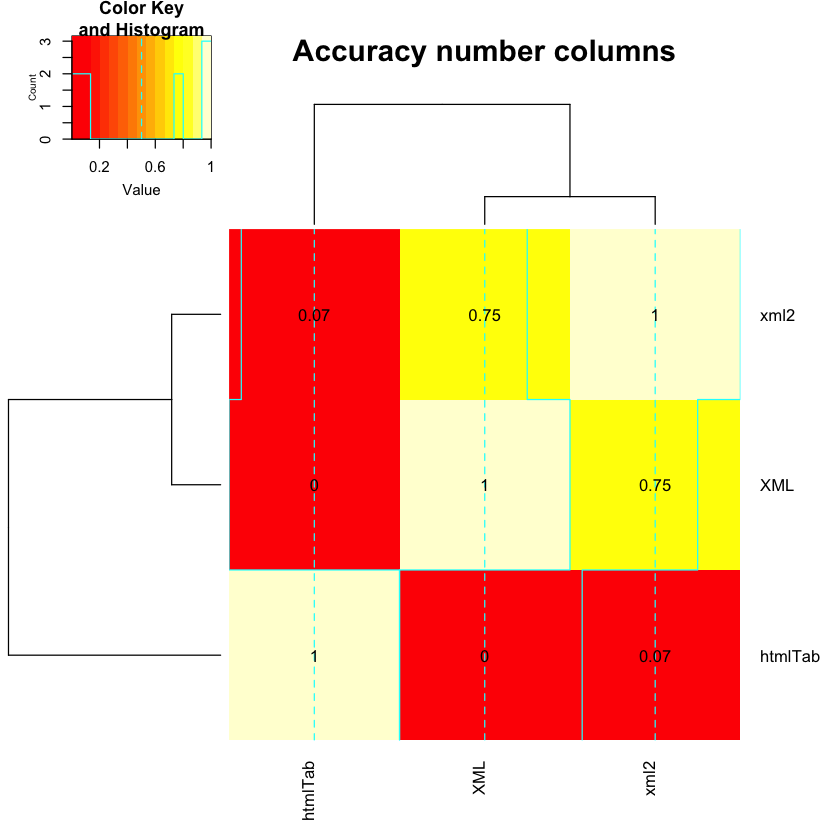

In [26]:
library(gplots)

lab <- c("XML", "xml2","htmlTab")
heatmap.2(mat_col, cellnote = matrix(sapply(mat_col, round, 2), 3,3), notecol="black",
          Rowv = T, labRow = lab, labCol = lab, cexRow =1, cexCol=1,dendrogram = "both", main = "Accuracy number columns")

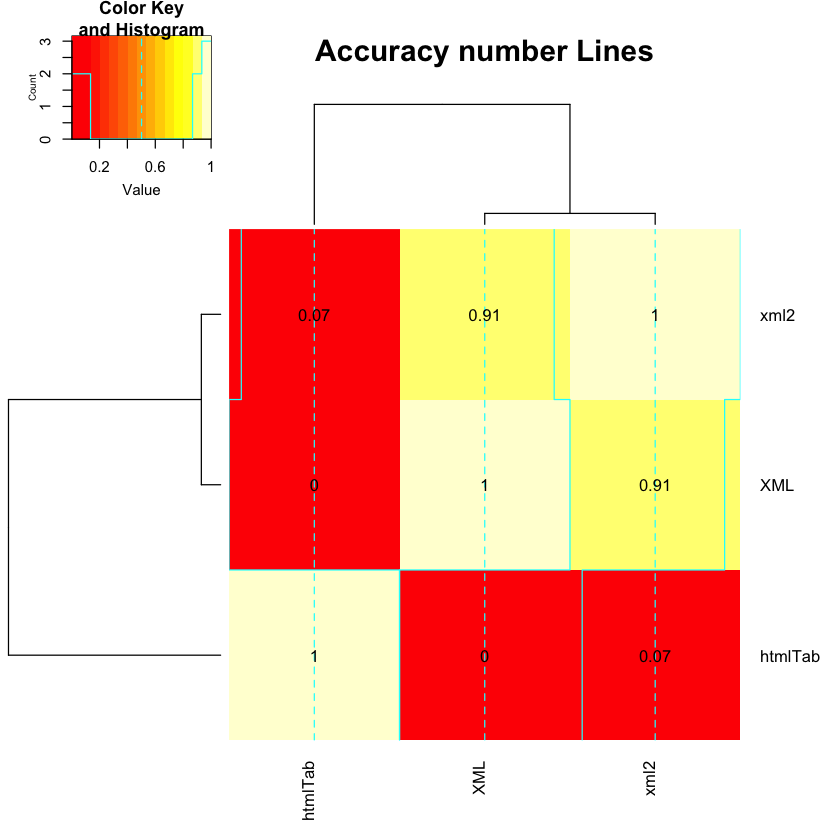

In [27]:
heatmap.2(mat_line, cellnote = matrix(sapply(mat_line, round, 2), 3,3), notecol="black",
          Rowv = T, labRow = lab, labCol = lab, cexRow =1, cexCol=1,dendrogram = "both", 
          main = "Accuracy number Lines")

htmlTab and XML find often the same number of lines. On the contrary, xml2 and XML seems to find the same number of columns.

If we trust the library when they agree about all, how many tables can be trusted?

In [28]:
nb <- sum((nbTablesXML==nbTablesXml2) & (nbLinesHtmlTab == nbLinesXML) & (nbLinesXml2 == nbLinesXML)
    & (nbColumnsHtmlTab == nbColumnsXML) & (nbColumnsXml2 == nbColumnsXML))
nb
cat(round(100*nb/length(links$V1),2), "% of the tables")

[1] 1

0.3 % of the tables

Number of columns

In [29]:
sum(nbColumnsXml2)
sum(nbColumnsXML)
sum(nbColumnsHtmlTab)

[1] 10261

[1] 3905

[1] -336

Number of lines

In [30]:
sum(nbLinesXml2)
sum(nbLinesXML)
sum(nbLinesHtmlTab)

[1] 14443

[1] 14815

[1] -336

## Conclusions

htmllab is slower than XML and xml2 (on wikipedia pages), it seems more efficient to use these two last libraries.

In most of the case, the number of tables extracted by xml & xml2 is the same. But Xml2 add some columns during the extraction, that probably do not exist, so XML may be be the best solution to extract tables from web pages.

But we can't test if the tables are well extracted, unless we have access to the "real" table with an other way.